<a href="https://colab.research.google.com/github/TausifAnsari/Traffic-Sign-Recogizer/blob/master/Traffic_Sign_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

In [0]:
# Install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [0]:
!mkdir dataset
!unzip /content/gtsrb-german-traffic-sign.zip -d /content/dataset

In [0]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class TrafficSignNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => BN => POOL
		model.add(Conv2D(8, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		model.add(Conv2D(64, (3, 3), padding="same", activation = "relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same", activation = "relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [14]:

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os

def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)

	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))

		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]

		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)

		# resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)

		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	# return a tuple of the data and labels
	return (data, labels)


# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# derive the path to the training and testing CSV files
trainPath = os.path.sep.join(["/content/dataset", "Train.csv"])
testPath = os.path.sep.join(["/content/dataset", "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split("/content/dataset", trainPath)
(testX, testY) = load_split("/content/dataset", testPath)

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

[INFO] loading training and testing data...


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total images
[INFO] processed 28000 total images
[

[INFO] compiling model...
[INFO] training network...
Epoch 1/30
612/612 [==============================] - 38s 62ms/step - loss: 2.7387 - acc: 0.2768 - val_loss: 2.9303 - val_acc: 0.2320
Epoch 2/30
612/612 [==============================] - 33s 54ms/step - loss: 1.4225 - acc: 0.5477 - val_loss: 1.1474 - val_acc: 0.6253
Epoch 3/30
612/612 [==============================] - 33s 55ms/step - loss: 0.9212 - acc: 0.7025 - val_loss: 0.7791 - val_acc: 0.7498
Epoch 4/30
612/612 [==============================] - 33s 54ms/step - loss: 0.6522 - acc: 0.7869 - val_loss: 0.4286 - val_acc: 0.8606
Epoch 5/30
612/612 [==============================] - 33s 54ms/step - loss: 0.4959 - acc: 0.8429 - val_loss: 0.4164 - val_acc: 0.8730
Epoch 6/30
612/612 [==============================] - 33s 54ms/step - loss: 0.4054 - acc: 0.8713 - val_loss: 0.4673 - val_acc: 0.8551
Epoch 7/30
612/612 [==============================] - 33s 55ms/step - loss: 0.3402 - acc: 0.8927 - val_loss: 0.3103 - val_acc: 0.9077
Epoch 8/3

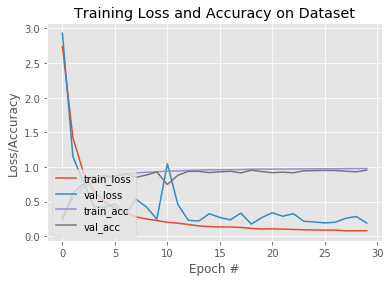

In [17]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3,
	classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# compile the model and train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BS,
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

# save the network to disk
print("[INFO] serializing network to ...")
model.save("traffic.h5")

# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

[INFO] loading model...
[INFO] predicting...


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


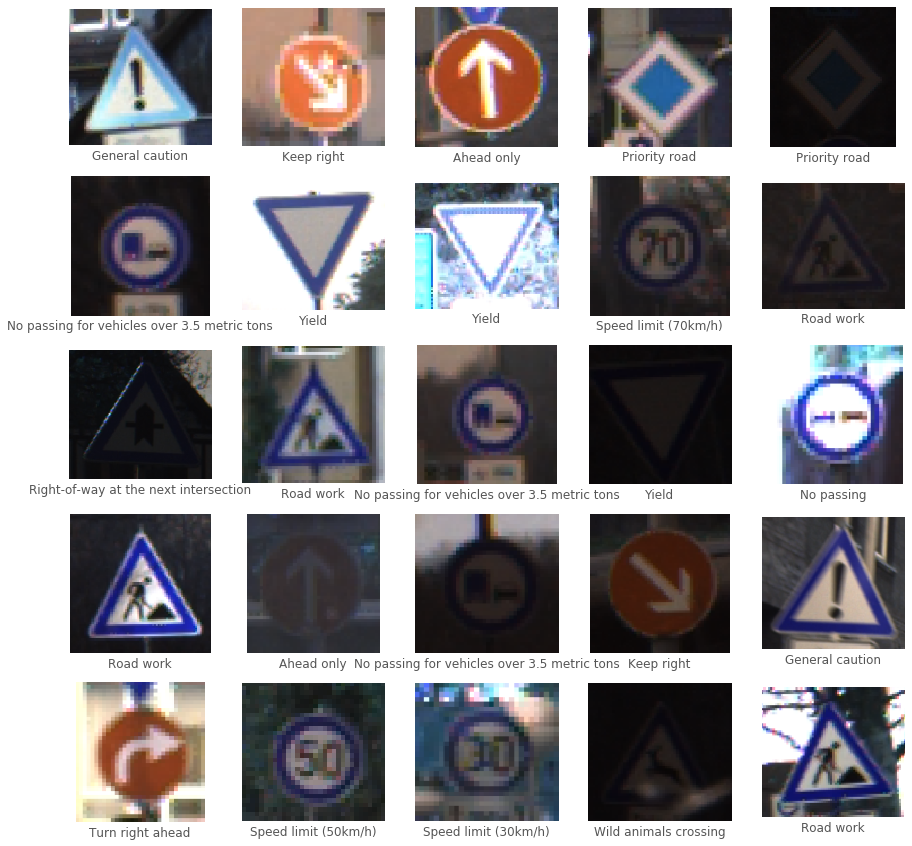

In [20]:
# USAGE
# python predict.py --model output/trafficsignnet.model --images gtsrb-german-traffic-sign/Test --examples examples

# import the necessary packages
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from skimage import transform
from skimage import exposure
from skimage import io
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os


# load the traffic sign recognizer model
print("[INFO] loading model...")
model = load_model("traffic.h5")

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# grab the paths to the input images, shuffle them, and grab a sample
print("[INFO] predicting...")
imagePaths = list(paths.list_images("/content/dataset/Train"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]

fig = plt.figure(figsize = (15,15))
#fig.suptitle("Prediction",fontsize=16)

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image, resize it to 32x32 pixels, and then apply
	# Contrast Limited Adaptive Histogram Equalization (CLAHE),
	# just like we did during training
	image = io.imread(imagePath)
	image = transform.resize(image, (32, 32))
	image = exposure.equalize_adapthist(image, clip_limit=0.1)

	# preprocess the image by scaling it to the range [0, 1]
	image = image.astype("float32") / 255.0
	image = np.expand_dims(image, axis=0)

	# make predictions using the traffic sign recognizer CNN
	preds = model.predict(image)
	j = preds.argmax(axis=1)[0]
	label = labelNames[j]

	# load the image using OpenCV, resize it, and draw the label
	# on it
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=128)
	plt.subplot(5,5,i+1)
	plt.xticks([])
	plt.yticks([])
	plt.grid(False)
	#plt.title("Sign :"+label)
	plt.xlabel(label)
	plt.imshow(image)
plt.show()
